# Segmentise subduction boundaries

Divide list of subduction segments into different subduction zones by identifying them with an integer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import gplately
from scipy import ndimage

%matplotlib inline

tessellation_threshold_radians = np.deg2rad(0.5)
extent_globe = [-180,180,-90,90]

In [2]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

subduction_lon         = df['lon']
subduction_lat         = df['lat']
subduction_angle       = df['angle']
subduction_norm        = df['norm']
subduction_pid_sub     = df['pid_sub']
subduction_pid_over    = df['pid_over']
subduction_length      = df['length']
subduction_convergence = df['vel']
subduction_dip         = df['slab_dip']

In [3]:
def segmentise_boundaries(subduction_lon, subduction_lat):
    
    earth_radius = 6371

    dtol = tessellation_threshold_radians*earth_radius + 5.0 # km
    segment_IDs = np.zeros(len(subduction_lon), dtype=int)

    index = 1
    for i in range(0, len(subduction_lon)-1):
        lon0 = subduction_lon[i]
        lat0 = subduction_lat[i]
        lon1 = subduction_lon[i+1]
        lat1 = subduction_lat[i+1]

        # distance between points (convert to unit sphere)
        
        xs, ys, zs = gplately.tools.lonlat2xyz([lon0,lon1], [lat0,lat1])
        dist = np.sqrt((xs[1]-xs[0])**2 + (ys[1]-ys[0])**2 + (zs[1]-zs[0])**2) * earth_radius

        if dist < dtol:
            # add to current segment
            segment_IDs[i] = index

        elif np.count_nonzero(segment_IDs == index) > 1:
            segment_IDs[i] = index
            index += 1
        else:
            pass

    unique_segment_IDs = set(segment_IDs)
    unique_segment_IDs.remove(0)
    return segment_IDs, unique_segment_IDs

In [4]:
segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat)

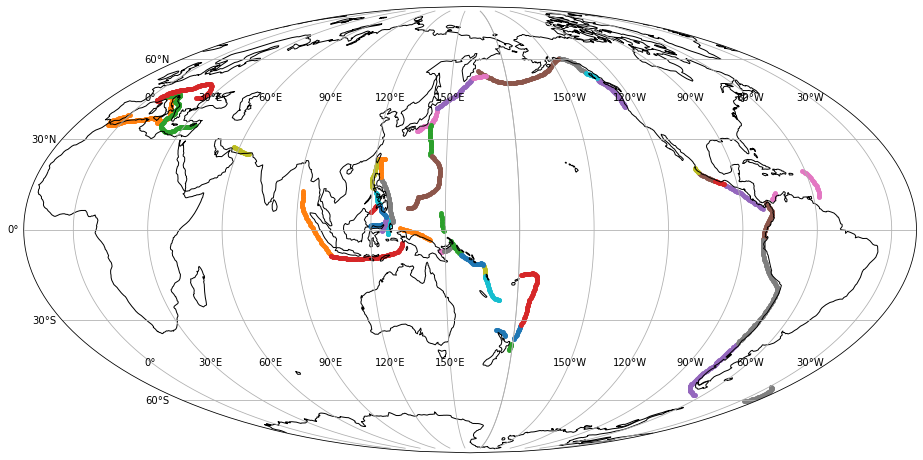

In [5]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = segment_IDs == seg_ID
    
    ax.scatter(subduction_lon[mask_segment],
               subduction_lat[mask_segment],
               c='C{}'.format(i), s=15, transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True, xlocs=np.arange(-180,200,30), ylocs=np.arange(-90,120,30))

## Subduction zone curvature

In [6]:
def smooth_1D(array, sigma):
    return ndimage.gaussian_filter1d(array, sigma)

In [7]:
segment_angle = np.zeros(df.shape[0])
subduction_radius = np.zeros(df.shape[0])

for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = segment_IDs == seg_ID
    
    segment_norm = subduction_norm[mask_segment].copy()

    # calculate angle between subuction zone segments
    dangle = np.gradient((segment_norm))
    
    # correct changes in plane
    dangle[dangle < 180] += 360
    dangle[dangle > 180] -= 360
    dangle[dangle < 90]  += 180
    dangle[dangle > 90]  -= 180
    
    distance = df['length'][mask_segment]
    radius = dangle / distance
    
    # apply some smoothing
    smooth_radius = smooth_1D(radius, 5)
    
    subduction_radius[mask_segment] = smooth_radius

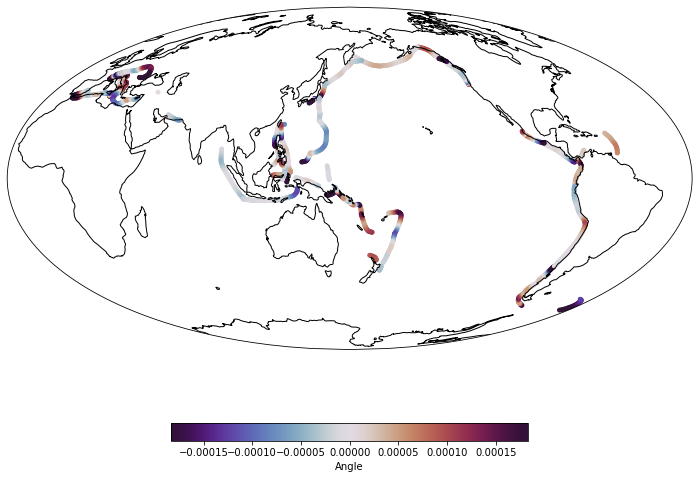

In [8]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

vmax = np.percentile(np.abs(subduction_radius), 90)

sc = ax.scatter(subduction_lon, subduction_lat, c=subduction_radius, s=15, transform=ccrs.PlateCarree(),
               cmap='twilight_shifted', vmin=-vmax, vmax=vmax)

ax.coastlines()
fig.colorbar(sc, shrink=0.4, orientation='horizontal', label='Angle')

This is similar to the subduction angle, which is the angle between the direction of the subducting plate and the trench normal.

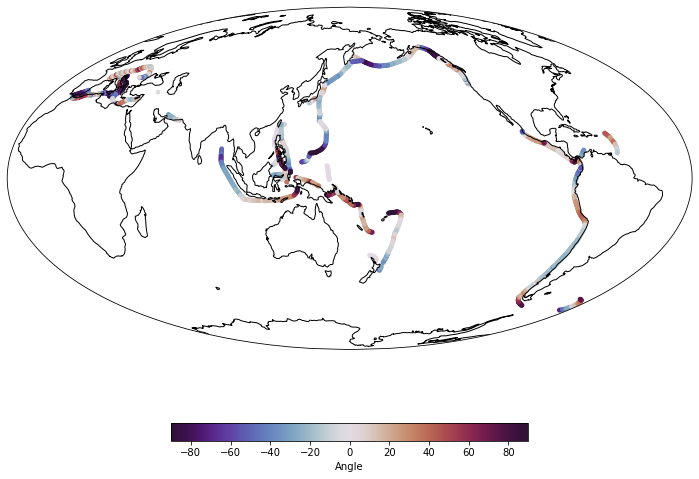

In [9]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

sc = ax.scatter(subduction_lon, subduction_lat, c=subduction_angle, s=15, transform=ccrs.PlateCarree(),
                vmin=-90, vmax=90, cmap='twilight_shifted')

ax.coastlines()
fig.colorbar(sc, shrink=0.4, orientation='horizontal', label='Angle')

In [10]:
# overwrite subduction data with newer version containing segment information
df = df.assign(segment_ID=segment_IDs)
df = df.assign(curvature=subduction_radius)
df.to_csv('data/subduction_data.csv')